# Titanic crush survivors predications
## Ofir Beck
## Saar Attarchi
## my kaggle profile: https://www.kaggle.com/ofirbeck9
## Our Objective is to predict which passengers have survived the Titanic crush, based on their info using KNN/SVM/NBC/LDA with feature selection and Bootstrap for validation

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [4]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import preprocessing

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV, SequentialFeatureSelector
from sklearn.model_selection import RepeatedKFold
from sklearn.utils import resample
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

from ydata_profiling import ProfileReport
import pandas as pd
import seaborn as sns # we will use it for showing the regression line
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
# define plt settings (you don't have to do it every time, you can you the default values)
plt.rcParams["font.size"] = 20
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["legend.fontsize"] = 20
plt.rcParams["figure.figsize"] = (20,10)

In [179]:
df_test = pd.read_csv('/kaggle/input/titanic/test.csv')
df_train = pd.read_csv('/kaggle/input/titanic/train.csv')

In [180]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [181]:
df_train.describe()

PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200

In [ ]:
ProfileReport(df_train, title="Titanic Report",explorative=True)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 12/12 [00:00<00:00, 62.71it/s][A


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### according to the features description - SibSp - num of siblings and Parch - number of parents on the ship. Both have weak connection to the target - we tried to make a new feature - FamilySize - that combine both(siblings + parents + the person himself)

In [183]:
def add_new_features(df):
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    return df

### We have noticed there are 2 rows without Embarked - so we removed them.
### Also a lot of rows were missing the age - we tried to remove them and fill the missing values with median, mean, min, max, and found that mean gave the best results

In [184]:
def fill_and_remove_rows(df):
    df = df.dropna(subset = ['Embarked'])
    df.loc[:, 'Age'] = df['Age'].fillna(df['Age'].mean())
    df = df.reset_index(drop=True)
    return df

### We have noticed both Embarked and Sex were categrized attributes, so we have performed one hot encoding for both(tried both dummy and not dummy encoding)

In [185]:
def perform_OneHotEncoding(df):
    categorical_features = ['Embarked', 'Sex']
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    ohe_colums = pd.DataFrame(
    encoder.fit_transform(df[categorical_features]),
    columns=encoder.get_feature_names_out(categorical_features),
   )
    df = df.drop(columns=categorical_features, axis=1).join(ohe_colums)
    return df

### Name, Cabin and Ticket are objects that we have found not meaningful to the model(no point to one-hot them) and feature selection can't have objects.
### We have tried the three options for feature selection: hybrid, backward and forward and found that hybrid gave the best results

In [186]:

def dropFeaturesWithFeatureSelection(df, n_to_select, method):
    df = df.drop(columns=['Cabin', 'Name', 'Ticket'], axis=1).copy()

    if 'Survived' in df.columns:
        t = df['Survived'].copy()
        X = df.drop(['Survived'], axis=1)
    else:
        raise ValueError("DataFrame must include 'Survived' column for feature selection.")

    scaler = preprocessing.StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    selected_columns = None

    if method == 'backward':
        selector = RFE(LogisticRegression(random_state=1), n_features_to_select=n_to_select).fit(X_scaled, t)
        selected_columns = X.columns[selector.support_]
        print("Backward feature selection chose:")
        display(X[selected_columns])

    elif method == 'forward':
        selector = SequentialFeatureSelector(LogisticRegression(random_state=1), direction='forward', n_features_to_select=n_to_select).fit(X_scaled, t)
        selected_columns = X.columns[selector.get_support()]
        print("Forward feature selection chose:")
        display(X[selected_columns])

    elif method == 'hybrid':
        selector = RFECV(LogisticRegression(random_state=1), cv=RepeatedKFold(n_splits=10, n_repeats=10, random_state=1)).fit(X_scaled, t)
        selected_columns = X.columns[selector.support_]
        print("Hybrid (RFECV) feature selection chose:")
        display(X[selected_columns])
        
    else:
        raise ValueError("Method must be 'forward', 'backward', or 'hybrid'.")

    return pd.concat([X[selected_columns], t], axis=1)


In [187]:
df_train = add_new_features(df_train)
df_train = fill_and_remove_rows(df_train)
df_train = perform_OneHotEncoding(df_train)
df_train = dropFeaturesWithFeatureSelection(df_train, 2, 'hybrid')

selected_columns = df_train.drop('Survived', axis=1).columns
X_test = df_test.copy()
X_test = add_new_features(X_test)
X_test = perform_OneHotEncoding(X_test)
X_test = X_test.reindex(columns=selected_columns)
X_test = X_test.fillna(X_test.mean())

Hybrid (RFECV) feature selection chose:


Pclass        Age  SibSp     Fare  FamilySize  Embarked_S  Sex_female  \
0         3  22.000000      1   7.2500           2         1.0         0.0   
1         1  38.000000      1  71.2833           2         0.0         1.0   
2         3  26.000000      0   7.9250           1         1.0         1.0   
3         1  35.000000      1  53.1000           2         1.0         1.0   
4         3  35.000000      0   8.0500           1         1.0         0.0   
..      ...        ...    ...      ...         ...         ...         ...   
884       2  27.000000      0  13.0000           1         1.0         0.0   
885       1  19.000000      0  30.0000           1         1.0         1.0   
886       3  29.642093      1  23.4500           4         1.0         1.0   
887       1  26.000000      0  30.0000           1         0.0         0.0   
888       3  32.000000      0   7.7500           1         0.0         0.0   

     Sex_male  
0         1.0  
1         0.0  
2         0.0  
3         0.0  
4         1.0  
..        ...  
884       1.0  
885       0.0  
886       0.0  
887       1.0  
888       1.0  

[889 rows x 8 columns]

In [188]:
df_train.head(100)

Pclass   Age  SibSp     Fare  FamilySize  Embarked_S  Sex_female  \
0        3  22.0      1   7.2500           2         1.0         0.0   
1        1  38.0      1  71.2833           2         0.0         1.0   
2        3  26.0      0   7.9250           1         1.0         1.0   
3        1  35.0      1  53.1000           2         1.0         1.0   
4        3  35.0      0   8.0500           1         1.0         0.0   
..     ...   ...    ...      ...         ...         ...         ...   
95       1  71.0      0  34.6542           1         0.0         0.0   
96       1  23.0      0  63.3583           2         0.0         0.0   
97       2  34.0      0  23.0000           2         1.0         1.0   
98       2  34.0      1  26.0000           2         1.0         0.0   
99       3  28.0      0   7.8958           1         1.0         1.0   

    Sex_male  Survived  
0        1.0         0  
1        0.0         1  
2        0.0         1  
3        0.0         1  
4        1.0         0  
..       ...       ...  
95       1.0         0  
96       1.0         1  
97       0.0         1  
98       1.0         0  
99       0.0         0  

[100 rows x 9 columns]

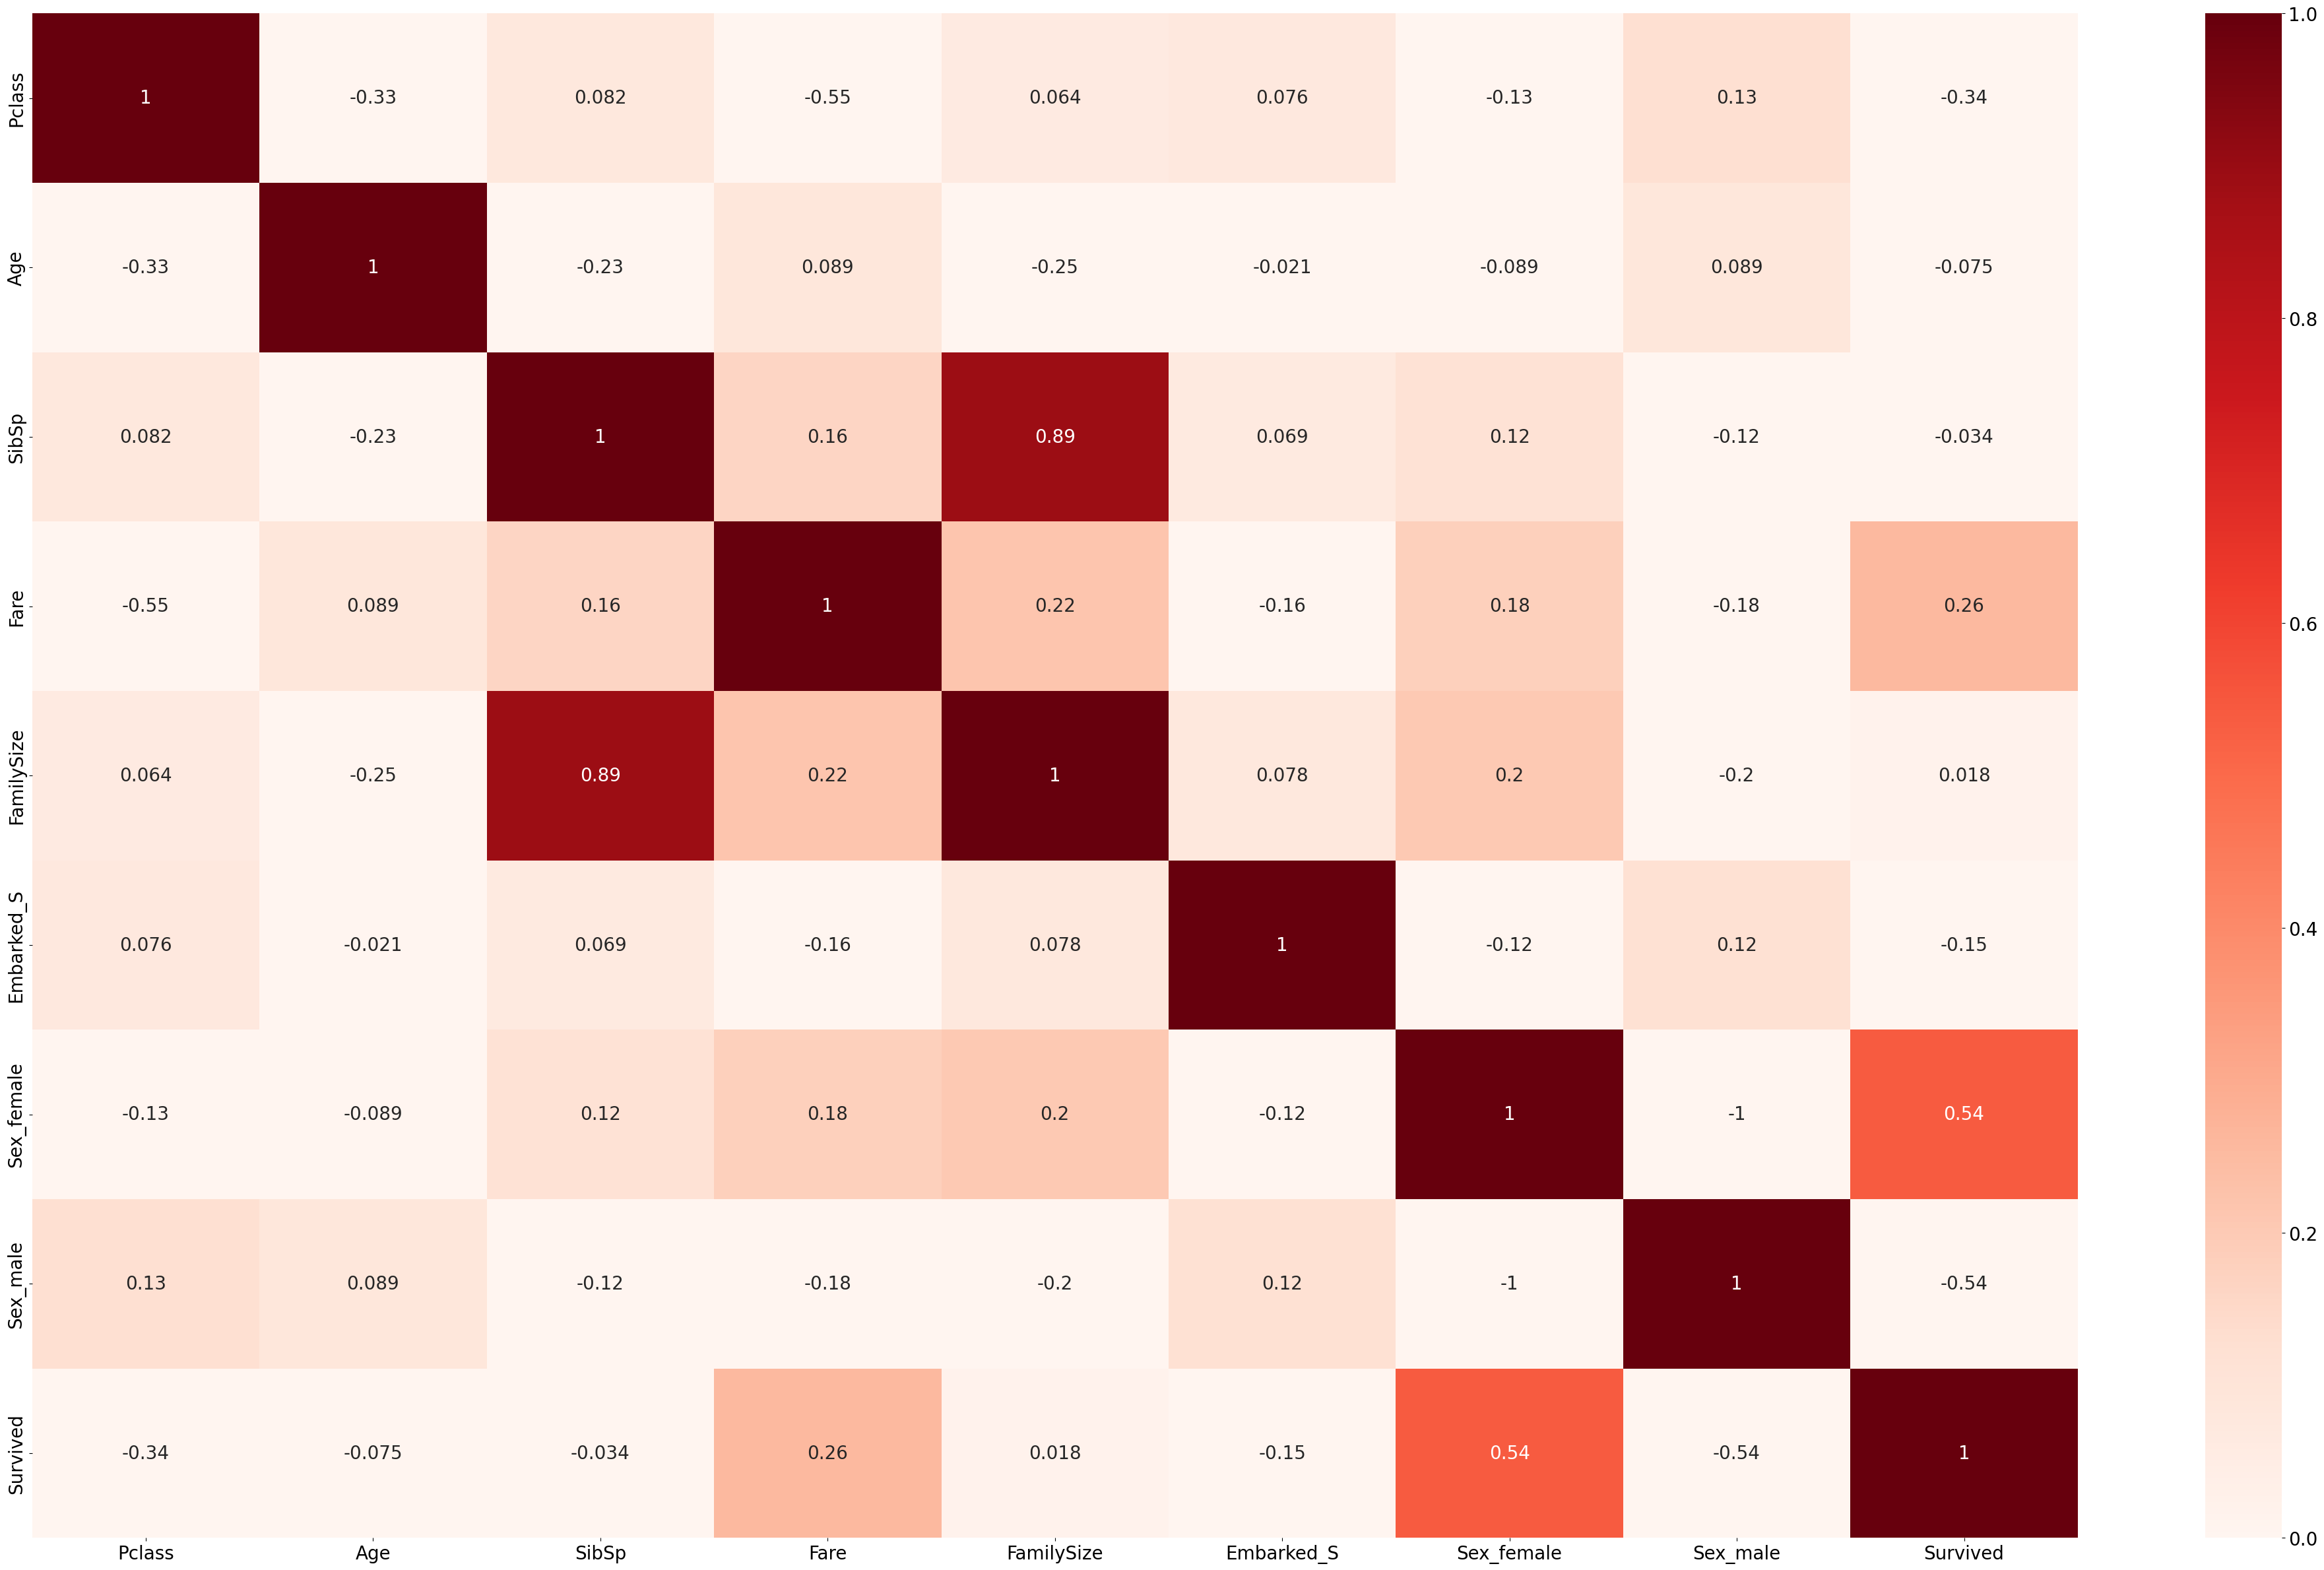

In [189]:
plt.figure(figsize=(50,30))
cor = df_train.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds, vmin=0, vmax=1)
plt.show()

In [190]:
t_train = df_train['Survived']
X_train = df_train.drop('Survived', axis=1)

## Searching for the best hyper params for each of both KNN and SVM using GridSearch

In [191]:
def choose_KNN_best_K(X_train, t_train):
    knn = KNeighborsClassifier()
    param_grid = {
        'n_neighbors': list(range(1, 51)), 
    }
    
    grid = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5)
    
    pipe = make_pipeline(preprocessing.StandardScaler(), grid)
    
    pipe.fit(X_train, t_train)
    
    best_model = pipe.named_steps['gridsearchcv']
    
    print("Best parameters:", best_model.best_params_)
    print("Best cross-validation score:", best_model.best_score_)
    
    return best_model.best_params_

In [192]:
def choose_SVC_best_params(X_train, t_train):
    svc = SVC()
    param_grid = {
        'C': [0.5, 1, 2],
        'gamma': ['scale', 0.01, 0.1]
    }

    grid = GridSearchCV(estimator=svc, param_grid=param_grid, cv=12, n_jobs=-1)

    pipe = make_pipeline(preprocessing.StandardScaler(), grid)
    pipe.fit(X_train, t_train)

    best_model = pipe.named_steps['gridsearchcv']

    print("Best parameters:", best_model.best_params_)
    print("Best cross-validation score:", best_model.best_score_)

    return best_model.best_params_

In [193]:
best_k = choose_KNN_best_K(X_train, t_train)['n_neighbors']
best_SVC_params = choose_SVC_best_params(X_train, t_train)
best_c = best_SVC_params['C']
best_gamma = best_SVC_params['gamma']

Best parameters: {'n_neighbors': 13}
Best cross-validation score: 0.8200469751793309
Best parameters: {'C': 1, 'gamma': 'scale'}
Best cross-validation score: 0.8290090090090091


## We have made a function for bootstarpping validation - it will get the name of the model - use its best hyperparams, validate and return the true vs predicted of each run in order to create the confusion matrix down the line
## We are able to use LDA here since according to the ProfileReport the features are approximately normally distributed within each class, one of LDA’s key assumptions

In [194]:
def bootstrap_validation(X_train, t_train, model_name):
    n_iterations = 100
    n_size = len(X_train)
    scores = []
    all_oob_true = []
    all_oob_pred = []
    for i in range(n_iterations):
        
        X_resampled, t_resampled = resample(X_train, t_train, replace=True, n_samples=n_size, random_state=i)

        all_indices = np.arange(n_size)
        resampled_indices = resample(all_indices, replace=True, n_samples=n_size, random_state=i)
        oob_mask = ~np.isin(all_indices, np.unique(resampled_indices))
        
        if oob_mask.sum() == 0:
            continue 
    
        X_oob = X_train[oob_mask]
        t_oob = t_train[oob_mask]
    
        if model_name == "KNN":
            model = KNeighborsClassifier(n_neighbors=best_k)
        if model_name == "NBC":
            model = GaussianNB()
        if model_name == "SVC":
            model = SVC(C=best_c, gamma=best_gamma)
        if model_name == "LDA":
            model = LinearDiscriminantAnalysis()
        
        model = make_pipeline(preprocessing.StandardScaler(), model)
        model.fit(X_resampled, t_resampled)
    
        t_pred = model.predict(X_oob)
        acc = accuracy_score(t_oob, t_pred)
        scores.append(acc)
        all_oob_true.extend(t_oob)
        all_oob_pred.extend(t_pred)
    mean_score = np.mean(scores)
    print(f"{model_name} Bootstrap Accuracy: {mean_score:.3f}")
    return all_oob_true, all_oob_pred, mean_score

In [195]:
# calculate precision, recall, specificity, fpr and accuracy
def precision(cm):
    tn, fp, fn, tp = cm.ravel()
    return tp/(tp+fp)

def recall(cm):
    tn, fp, fn, tp = cm.ravel()
    return tp/(tp+fn)

def specificity(cm):
    tn, fp, fn, tp = cm.ravel()
    return tn/(tn+fp)

def fpr(cm):
    tn, fp, fn, tp = cm.ravel()
    return fp/(fp+tn)

def accuracy(cm):
    tn, fp, fn, tp = cm.ravel()
    return (tp+tn)/(tp+tn+fp+fn)

# calculate f1 and balanced accuracy
def f1(cm):
    precision_calc = precision(cm)
    recall_calc = recall(cm)
    return (2*precision_calc*recall_calc)/(precision_calc+recall_calc)

def balanced_accuracy(cm):
    recall_calc = recall(cm)
    specificity_calc = specificity(cm)
    return (recall_calc+specificity_calc)/2

In [196]:
def create_confusion_matrix(t_val, y_val):
    cm_val = confusion_matrix(t_val, y_val)
    print(f'Val:   precision {precision(cm_val):.2f}, recall {recall(cm_val):.2f}, specificity {specificity(cm_val):.2f}, fpr {fpr(cm_val):.2f}, accuracy {accuracy(cm_val):.2f}')
    print(f'Val:   f1 {f1(cm_val):.2f}, balanced_accuracy {balanced_accuracy(cm_val):.2f}')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_val)
    disp.plot()
    plt.title('Validation Confusion Matrix')
    plt.show()

# Display KPI and confusion matrix for bootstrap validation for KNN, NBC, SVC and LDA

For KNN:
KNN Bootstrap Accuracy: 0.803
Val:   precision 0.77, recall 0.68, specificity 0.88, fpr 0.12, accuracy 0.80
Val:   f1 0.73, balanced_accuracy 0.78


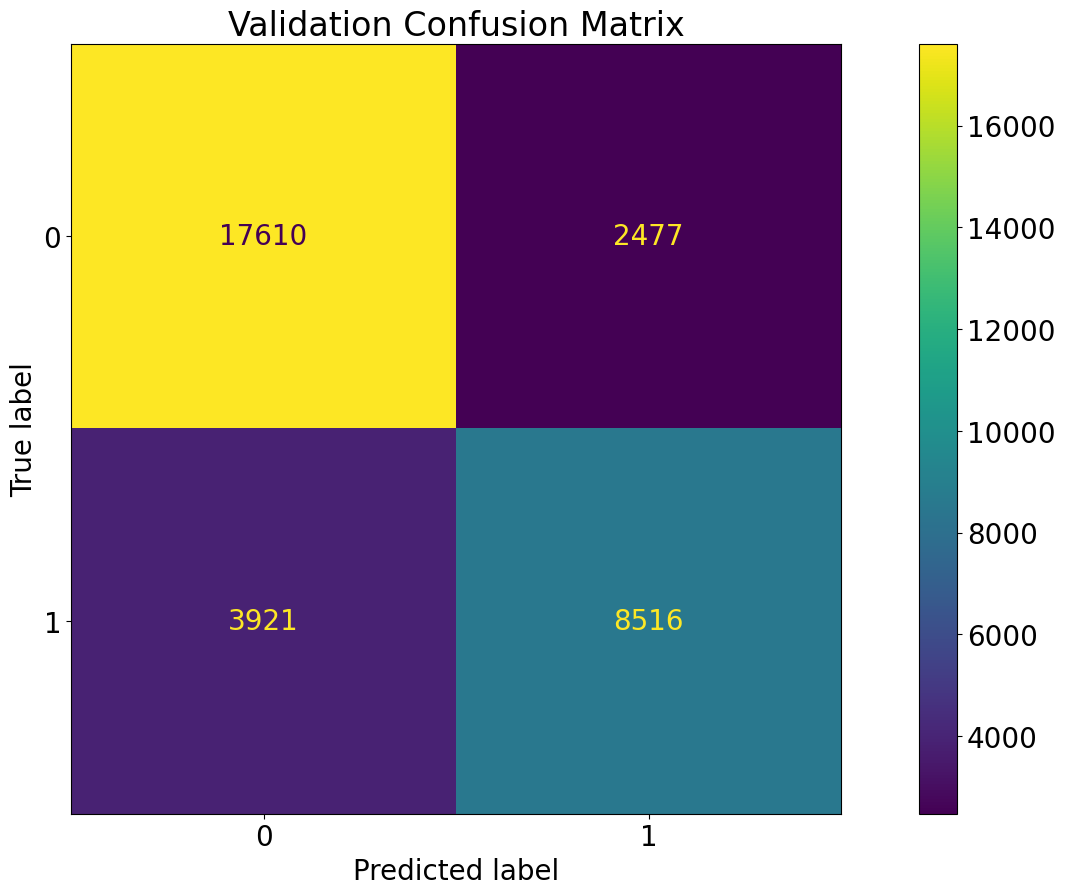

In [197]:
print("For KNN:")
t_val_KNN, y_val_KNN, KNN_score = bootstrap_validation(X_train, t_train, "KNN")
create_confusion_matrix(t_val_KNN, y_val_KNN)

For NBC:
NBC Bootstrap Accuracy: 0.796
Val:   precision 0.75, recall 0.71, specificity 0.85, fpr 0.15, accuracy 0.80
Val:   f1 0.73, balanced_accuracy 0.78


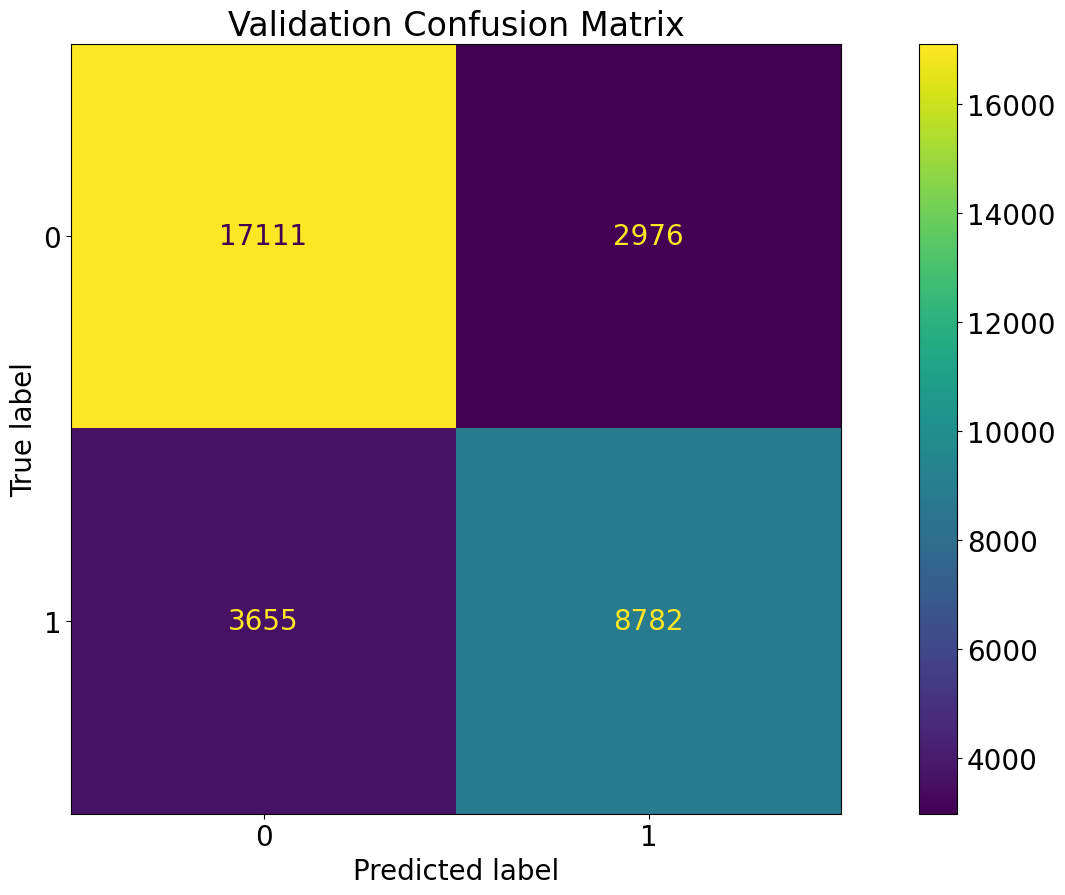

In [198]:
print("For NBC:")
t_val_NBC, y_val_NBC, NBC_score = bootstrap_validation(X_train, t_train, "NBC")
create_confusion_matrix(t_val_NBC, y_val_NBC)

For SVC:
SVC Bootstrap Accuracy: 0.821
Val:   precision 0.83, recall 0.67, specificity 0.92, fpr 0.08, accuracy 0.82
Val:   f1 0.74, balanced_accuracy 0.79


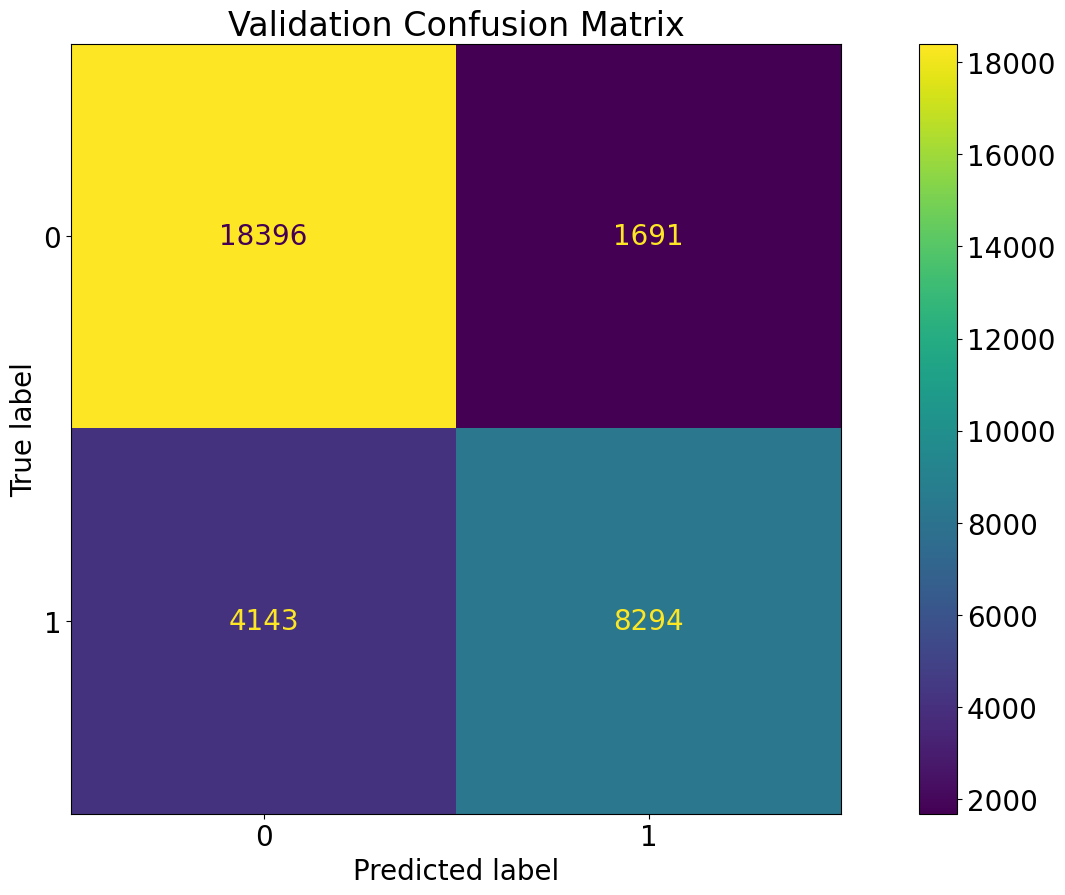

In [199]:
print("For SVC:")
t_val_SVC, y_val_SVC, SVC_score = bootstrap_validation(X_train, t_train, "SVC")
create_confusion_matrix(t_val_SVC, y_val_SVC)

For LDA:
LDA Bootstrap Accuracy: 0.795
Val:   precision 0.75, recall 0.69, specificity 0.86, fpr 0.14, accuracy 0.80
Val:   f1 0.72, balanced_accuracy 0.78


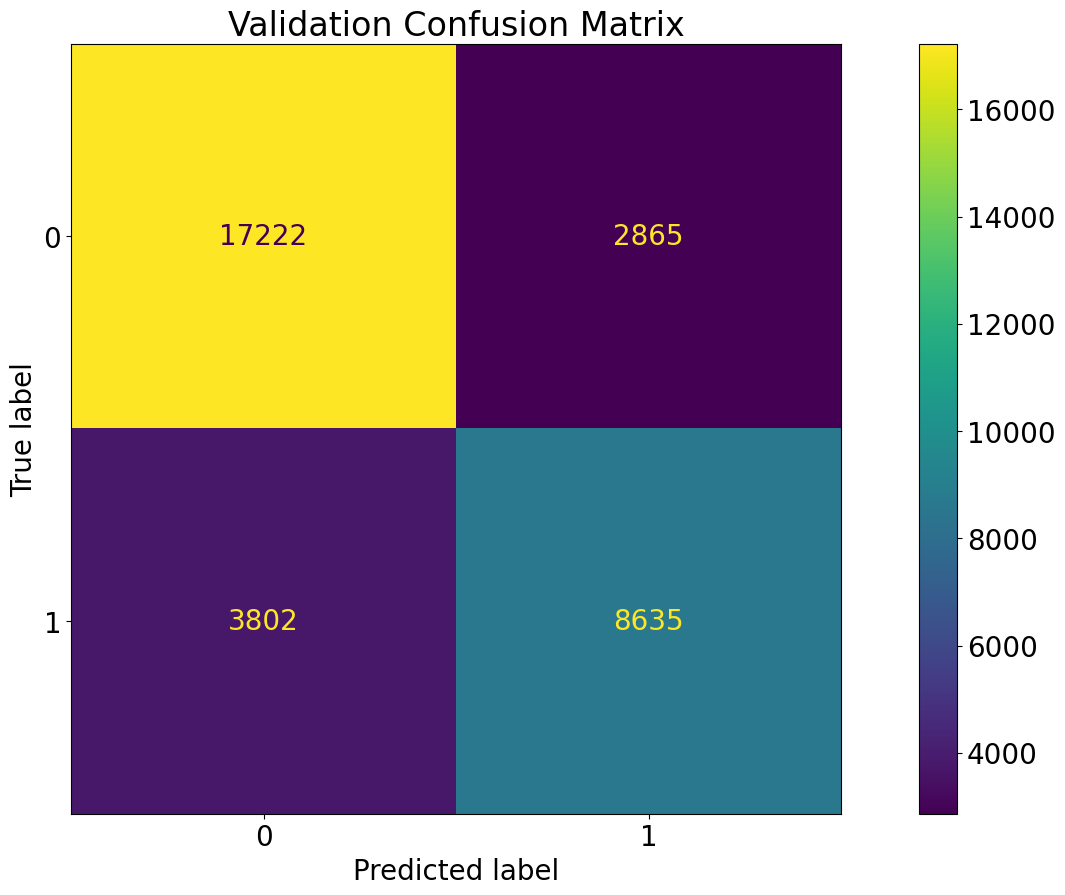

In [200]:
print("For LDA:")
t_val_LDA, y_val_LDA, LDA_score = bootstrap_validation(X_train, t_train, "LDA")
create_confusion_matrix(t_val_LDA, y_val_LDA)

## Precision When the model predicts survival - how often is it correct.
## Recall : out of all actual survivors, how many did we correctly identify.
## Specificity: out of all non-survivors, how many were correctly predicted as not surviving
## Accuracy: how many total predictions were correct

## When comparing the models KPIs we can see:

### SVC performed best overall, achieving the highest bootstrap accuracy, and the highest score in most other KPIs(other than recall - in which it performed the worst - meaning it missed more positives)

### KNN comes in second with a good balance between catching survivors (recall 0.68) and keeping false alarms low (specificity 0.88). It’s better than SVC at finding true positives, which is important here.

### NBC and LDA perform similarly. NBC has a slightly better recall, meaning it finds more survivors, but LDA has better specificity, so it makes fewer false positive mistakes. LDA’s lower F1 shows it’s less balanced overall.

# Comparision of the models by the bootstrap accuracy

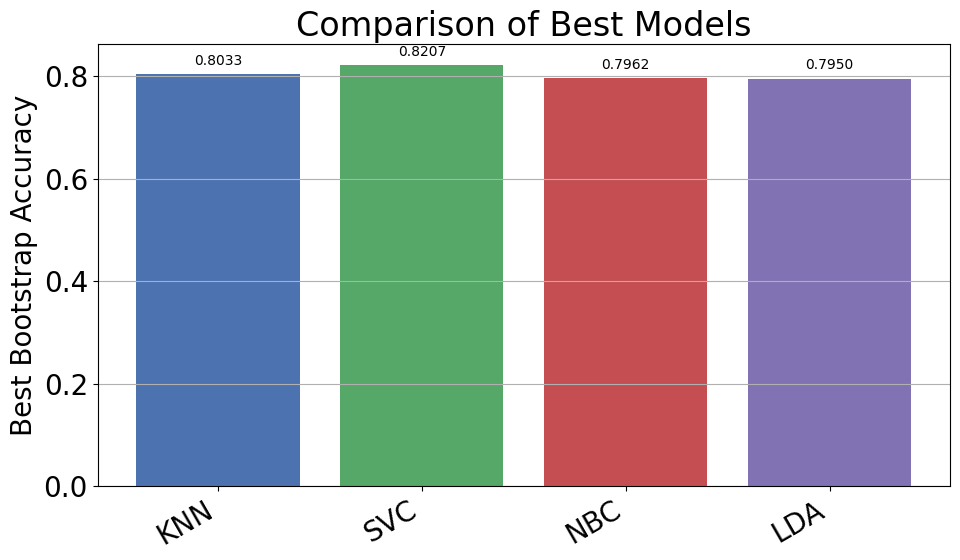

In [201]:
model_results = {"KNN": KNN_score, "SVC": SVC_score, "NBC": NBC_score, "LDA": LDA_score}
model_names = list(model_results.keys())
bootstrap_scores = list(model_results.values())

plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, bootstrap_scores, color=["#4C72B0", "#55A868", "#C44E52", "#8172B3"])
plt.ylabel("Best Bootstrap Accuracy")
plt.title("Comparison of Best Models")
plt.grid(True, axis='y')
for bar, score in zip(bars, bootstrap_scores):
    plt.text(bar.get_x() + bar.get_width() / 2,bar.get_height() + bar.get_height() * 0.015,f"{score:.4f}",ha='center', va='bottom', fontsize=10)
plt.xticks(rotation=30, ha='right')

plt.tight_layout()
plt.show()

# Choose the model with the highest bootstrap accuracy

Score on train 0.8391451068616423


<Axes: >

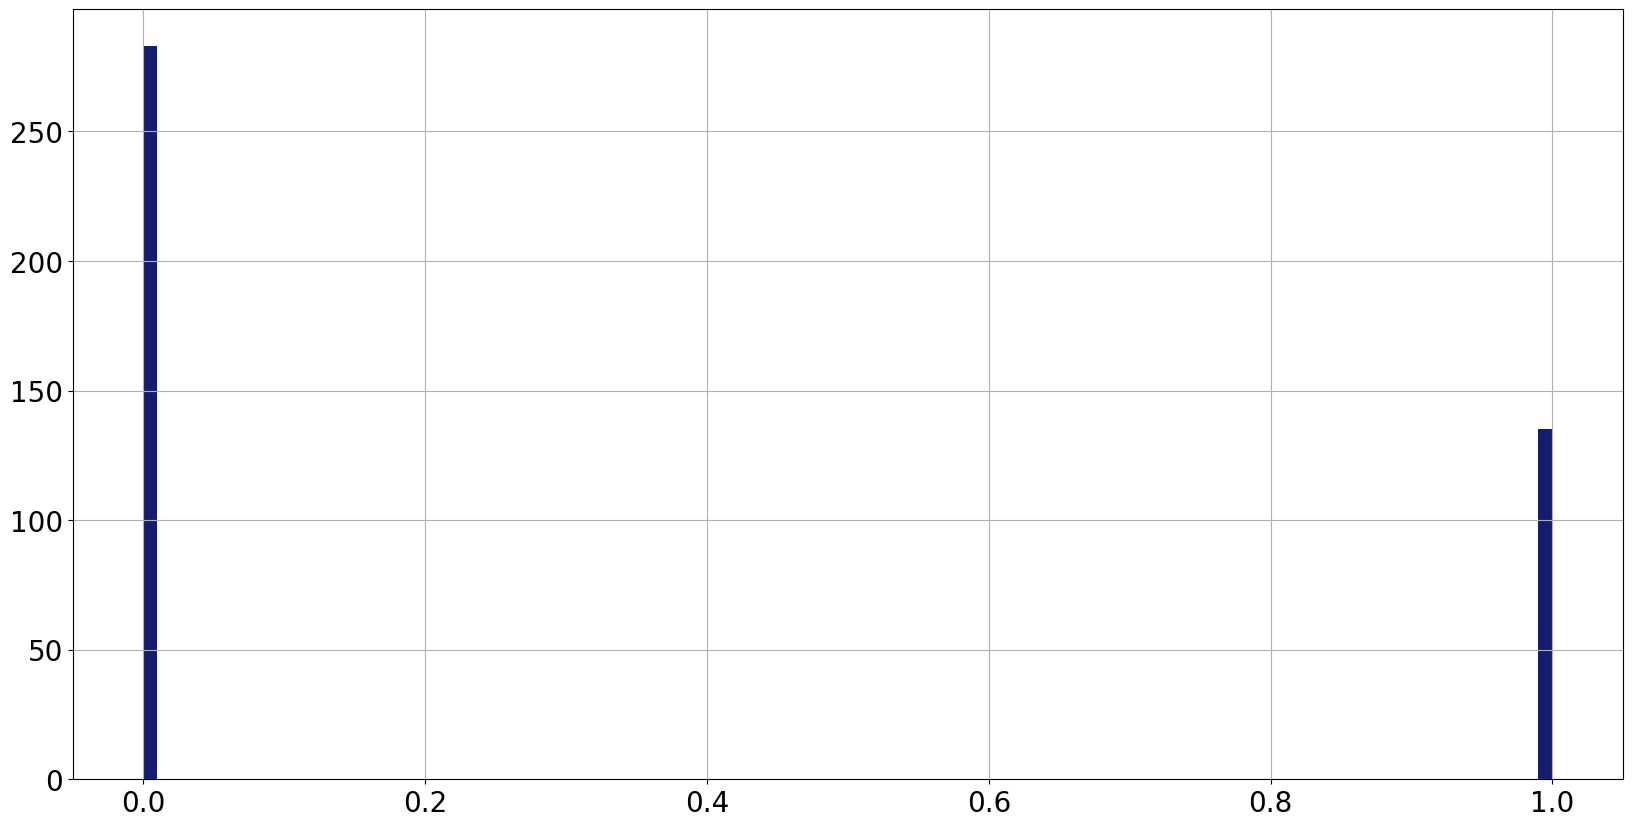

In [202]:
best_model_name = max(model_results, key=model_results.get)

if best_model_name == "KNN":
    final_model = KNeighborsClassifier(n_neighbors=best_k)
if best_model_name == "NBC":
    final_model = GaussianNB()
if best_model_name == "SVC":
    final_model = SVC(C=best_c, gamma=best_gamma)
if best_model_name == "LDA":
    final_model = LinearDiscriminantAnalysis()
    
final_model = make_pipeline(preprocessing.StandardScaler(), final_model).fit(X_train, t_train)
print('Score on train', final_model.score(X_train, t_train))
predictions = final_model.predict(X_test)
output = pd.DataFrame({'PassengerId': df_test['PassengerId'], 'Survived': predictions})
pd.Series(predictions).hist(bins = 100, color = '#161D6F')

In [203]:
output.to_csv('submission.csv', index=False)

output.describe()

PassengerId    Survived
count   418.000000  418.000000
mean   1100.500000    0.322967
std     120.810458    0.468170
min     892.000000    0.000000
25%     996.250000    0.000000
50%    1100.500000    0.000000
75%    1204.750000    1.000000
max    1309.000000    1.000000

# Summary:
## We have exprienced with many approches while trying to train the best model:
## 1. We have tried using the 3 types of feature selection: hybrid, backward and forward and we saw that hybrid gave the best results.
## 2. We have tried using all the 4 models above with each of the feature selection types to find which model suits the best - and found that SVC with hybrid brought the best results and the best KPI's on the bootstrap validation.
## 3. We have perform grid search on KNN and SVC to find the best suited hyperparams for this task.

# Our submissions scores:

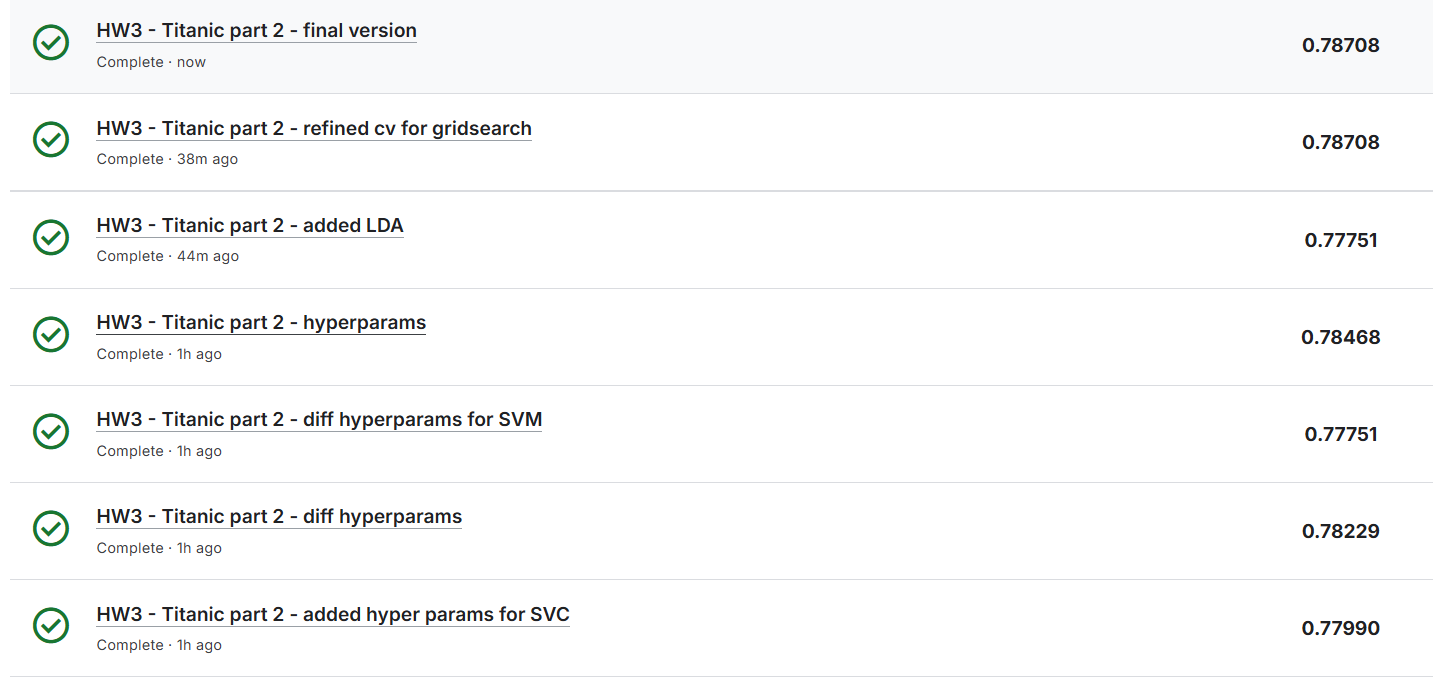

# Our highest score 0.78708

# Our leaderboard placement

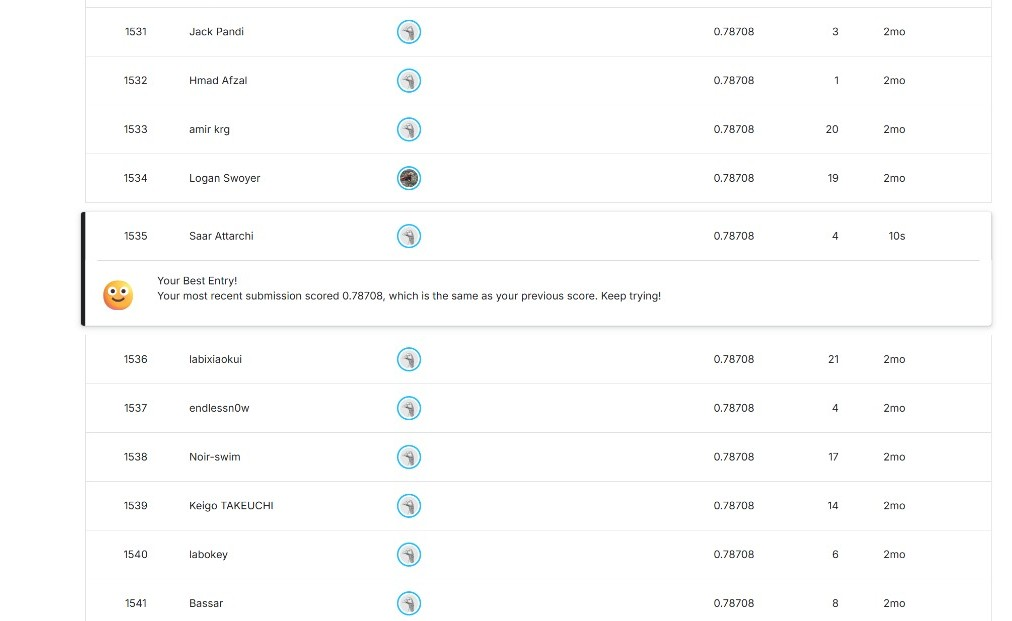